In [4]:
! [ -e /content ] && pip install -Uqq fastai

     |████████████████████████████████| 194kB 2.8MB/s 
     |████████████████████████████████| 51kB 4.3MB/s 


You should aim to have an iteration speed of no more than a couple of minutes—that is, when you come up with a new idea you want to try out, you should be able to train a model and see how it goes within a couple of minutes. If it's taking longer to do an experiment, think about how you could cut down your dataset, or simplify your model, to improve your experimentation speed. The more experiments you can do, the better!

In [5]:
from fastai.vision.all import *
path = untar_data(URLs.IMAGENETTE)
Path.BASE_PATH = path

In [7]:
path.ls()

(#2) [Path('train'),Path('val')]

In [6]:
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(460),
                   batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = dblock.dataloaders(path, bs=64)

In [9]:
dls.vocab

['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']

In [8]:
dblock.summary(path/'train')

Setting-up type transforms pipelines
Found 9469 items
2 datasets of sizes 7576,1893
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/imagenette2/train/n03394916/n03394916_49493.JPEG
    applying PILBase.create gives
      PILImage mode=RGB size=540x430
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/imagenette2/train/n03394916/n03394916_49493.JPEG
    applying parent_label gives
      n03394916
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(5)

Final sample: (PILImage mode=RGB size=540x430, TensorCategory(5))


Setting up after_item: Pipeline: Resize -- {'size': (460, 460), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_

In [ ]:
model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(2, 3e-3)

#Normalization

The pretrained model only knows how to work with data of the type that it has seen before. If the average pixel value was 0 in the data it was trained with, but your data has 0 as the minimum possible value of a pixel, then the model is going to be seeing something very different to what is intended! 

This means that when you distribute a model, you need to also distribute the statistics used for normalization, since anyone using it for inference, or transfer learning, will need to use the same statistics. By the same token, if you're using a model that someone else has trained, make sure you find out what normalization statistics they used, and match them.


In [11]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([0.4541, 0.4636, 0.4290]), TensorImage([0.2723, 0.2620, 0.2865]))

In [15]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [16]:
def get_dls(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(460),
                   batch_tfms=[*aug_transforms(size=size, min_scale=0.75),
                               Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(path, bs=bs)

In [17]:
dls = get_dls(64, 224)

In [18]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([-0.1932, -0.1027,  0.0083]),
 TensorImage([1.1652, 1.1619, 1.2045]))

In [ ]:
model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(2, 3e-3)

#Progressive Resizing

one of the most important innovations was something very simple: start training using small images, and end training using large images. Spending most of the epochs training with small images, helps training complete much faster. Completing training using large images makes the final accuracy much higher. We call this approach progressive resizing.

the kinds of features that are learned by convolutional neural networks are not in any way specific to the size of the image—early layers find things like edges and gradients, and later layers may find things like noses and sunsets. So, when we change image size in the middle of training, it doesn't mean that we have to find totally different parameters for our model.


There is an additional benefit to progressive resizing: it is another form of data augmentation. Therefore, you should expect to see better generalization of your models that are trained with progressive resizing.


In [ ]:
dls = get_dls(128, 128)
learn = Learner(dls, xresnet50(), loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy)
learn.fit_one_cycle(4, 3e-3)

In [ ]:
#replace the DataLoaders inside the Learner, and fine-tune
learn.dls = get_dls(64, 224)
learn.fine_tune(5, 1e-3)

As you can see, we're getting much better performance, and the initial training on small images was much faster on each epoch.

You can repeat the process of increasing size and training more epochs as many times as you like, for as big an image as you wish—but of course, you will not get any benefit by using an image size larger than the size of your images on disk.

Note that for transfer learning, progressive resizing may actually hurt performance. This is most likely to happen if your pretrained model was quite similar to your transfer learning task and dataset and was trained on similar-sized images, so the weights don't need to be changed much. In that case, training on smaller images may damage the pretrained weights.

On the other hand, if the transfer learning task is going to use images that are of different sizes, shapes, or styles than those used in the pretraining task, progressive resizing will probably help. As always, the answer to "Will it help?" is "Try it!"

Another thing we could try is applying data augmentation to the validation set. Up until now, we have only applied it on the training set; the validation set always gets the same images. But maybe we could try to make predictions for a few augmented versions of the validation set and average them. We'll consider this approach next.

#Test Time Augmentation

in a multi-label dataset sometimes there are small objects toward the edges of an image; these could be entirely cropped out by center cropping. Even for problems such as our pet breed classification example, it's possible that some critical feature necessary for identifying the correct breed, such as the color of the nose, could be cropped out.

One solution to this problem is to avoid random cropping entirely. Instead, we could simply squish or stretch the rectangular images to fit into a square space. But then we miss out on a very useful data augmentation, and we also make the image recognition more difficult for our model, because it has to learn how to recognize squished and squeezed images, rather than just correctly proportioned images.

Another solution is to not just center crop for validation, but instead to select a number of areas to crop from the original rectangular image, pass each of them through our model, and take the maximum or average of the predictions. In fact, we could do this not just for different crops, but for different values across all of our test time augmentation parameters. This is known as *test time augmentation* (TTA).

Depending on the dataset, test time augmentation can result in dramatic improvements in accuracy. It does not change the time required to train at all, but will increase the amount of time required for validation or inference by the number of test-time-augmented images requested. By default, fastai will use the unaugmented center crop image plus four randomly augmented images.

You can pass any DataLoader to fastai's tta method; by default, it will use your validation set

In [ ]:
preds,targs = learn.tta()
accuracy(preds, targs).item()

As we can see, using TTA gives us good a boost in performance, with no additional training required. However, it does make inference slower—if you're averaging five images for TTA, inference will be five times slower.


#Mixup

Mixup, introduced in the 2017 paper ["*mixup*: Beyond Empirical Risk Minimization"](https://arxiv.org/abs/1710.09412) byHongyi Zhang et al., is a very powerful data augmentation technique that can provide dramatically higher accuracy, especially when you don't have much data and don't have a pretrained model that was trained on data similar to your dataset. The paper explains: "While data augmentation consistently leads to improved generalization, the procedure is dataset-dependent, and thus requires the use of expert knowledge." For instance, it's common to flip images as part of data augmentation, but should you flip only horizontally, or also vertically? The answer is that it depends on your dataset. In addition, if flipping (for instance) doesn't provide enough data augmentation for you, you can't "flip more." It's helpful to have data augmentation techniques where you can "dial up" or "dial down" the amount of change, to see what works best for you.

Mixup works as follows, for each image:

1. Select another image from your dataset at random.
1. Pick a weight at random.
1. Take a weighted average (using the weight from step 2) of the selected image with your image; this will be your independent variable.
1. Take a weighted average (with the same weight) of this image's labels with your image's labels; this will be your dependent variable.

In pseudocode, we're doing this (where `t` is the weight for our weighted average):

```
image2,target2 = dataset[randint(0,len(dataset)]
t = random_float(0.5,1.0)
new_image = t * image1 + (1-t) * image2
new_target = t * target1 + (1-t) * target2
```

For this to work, our targets need to be one-hot encoded. The paper describes this using the equations shown in <<mixup>> where $\lambda$ is the same as `t` in our pseudocode:

In [20]:
get_image_files(path/'train'/'n03028079')

(#941) [Path('train/n03028079/n03028079_3804.JPEG'),Path('train/n03028079/n03028079_86296.JPEG'),Path('train/n03028079/n03028079_55583.JPEG'),Path('train/n03028079/n03028079_15739.JPEG'),Path('train/n03028079/n03028079_50476.JPEG'),Path('train/n03028079/n03028079_12426.JPEG'),Path('train/n03028079/n03028079_39103.JPEG'),Path('train/n03028079/n03028079_4794.JPEG'),Path('train/n03028079/ILSVRC2012_val_00024897.JPEG'),Path('train/n03028079/ILSVRC2012_val_00017783.JPEG')...]

In [22]:
get_image_files(path/'train'/'n03425413')

(#931) [Path('train/n03425413/ILSVRC2012_val_00017469.JPEG'),Path('train/n03425413/n03425413_8363.JPEG'),Path('train/n03425413/n03425413_9585.JPEG'),Path('train/n03425413/n03425413_19885.JPEG'),Path('train/n03425413/n03425413_14645.JPEG'),Path('train/n03425413/n03425413_20166.JPEG'),Path('train/n03425413/n03425413_19363.JPEG'),Path('train/n03425413/n03425413_8208.JPEG'),Path('train/n03425413/n03425413_8863.JPEG'),Path('train/n03425413/n03425413_503.JPEG')...]

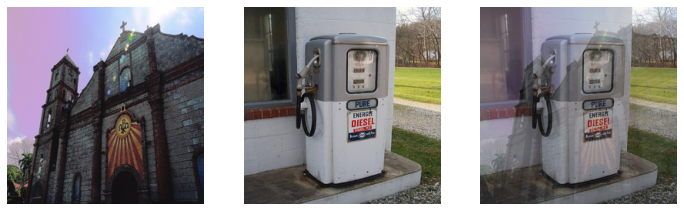

In [23]:
#id mixup_example
#caption Mixing a church and a gas station
#alt An image of a church, a gas station and the two mixed up.
church = PILImage.create(path/'train'/'n03028079'/'n03028079_3804.JPEG')
gas = PILImage.create(path/'train'/'n03425413'/'ILSVRC2012_val_00017469.JPEG')
church = church.resize((256,256))
gas = gas.resize((256,256))
tchurch = tensor(church).float() / 255.
tgas = tensor(gas).float() / 255.

_,axs = plt.subplots(1, 3, figsize=(12,4))
show_image(tchurch, ax=axs[0]);
show_image(tgas, ax=axs[1]);
show_image((0.3*tchurch + 0.7*tgas), ax=axs[2]);

The third image is built by adding 0.3 times the first one and 0.7 times the second. In this example, should the model predict "church" or "gas station"? The right answer is 30% church and 70% gas station, since that's what we'll get if we take the linear combination of the one-hot-encoded targets. For instance, suppose we have 10 classes and "church" is represented by the index 2 and "gas station" is reprsented by the index 7, the one-hot-encoded representations are:
```
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0] and [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
```
so our final target is:
```
[0, 0, 0.3, 0, 0, 0, 0, 0.7, 0, 0]
```

This all done for us inside fastai by adding a *callback* to our `Learner`. `Callback`s are what is used inside fastai to inject custom behavior in the training loop (like a learning rate schedule, or training in mixed precision). We'll be learning all about callbacks, including how to make your own, in <<chapter_accel_sgd>>. For now, all you need to know is that you use the `cbs` parameter to `Learner` to pass callbacks.

Here is how we train a model with Mixup:

```python
model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=MixUp)
learn.fit_one_cycle(5, 3e-3)
```

#label smoothing

In the theoretical expression of loss, in classification problems, our targets are one-hot encoded (in practice we tend to avoid doing this to save memory, but what we compute is the same loss as if we had used one-hot encoding). That means the model is trained to return 0 for all categories but one, for which it is trained to return 1. Even 0.999 is not "good enough", the model will get gradients and learn to predict activations with even higher confidence. This encourages overfitting and gives you at inference time a model that is not going to give meaningful probabilities: it will always say 1 for the predicted category even if it's not too sure, just because it was trained this way.

This can become very harmful if your data is not perfectly labeled. In the bear classifier we studied in <<chapter_production>>, we saw that some of the images were mislabeled, or contained two different kinds of bears. In general, your data will never be perfect. Even if the labels were manually produced by humans, they could make mistakes, or have differences of opinions on images that are harder to label.

Instead, we could replace all our 1s with a number a bit less than 1, and our 0s by a number a bit more than 0, and then train. This is called *label smoothing*. By encouraging your model to be less confident, label smoothing will make your training more robust, even if there is mislabeled data. The result will be a model that generalizes better.

This is how label smoothing works in practice: we start with one-hot-encoded labels, then replace all 0s with $\frac{\epsilon}{N}$ (that's the Greek letter *epsilon*, which is what was used in the [paper that introduced label smoothing](https://arxiv.org/abs/1512.00567) and is used in the fastai code), where $N$ is the number of classes and $\epsilon$ is a parameter (usually 0.1, which would mean we are 10% unsure of our labels). Since we want the labels to add up to 1, replace the 1 by $1-\epsilon + \frac{\epsilon}{N}$. This way, we don't encourage the model to predict something overconfidently. In our Imagenette example where we have 10 classes, the targets become something like (here for a target that corresponds to the index 3):
```
[0.01, 0.01, 0.01, 0.91, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
```
In practice, we don't want to one-hot encode the labels, and fortunately we won't need to (the one-hot encoding is just good to explain what label smoothing is and visualize it).

To use this in practice, we just have to change the loss function in our call to `Learner`:

```python
model = xresnet50()
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), 
                metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)
```

Like with Mixup, you won't generally see significant improvements from label smoothing until you train more epochs. Try it yourself and see: how many epochs do you have to train before label smoothing shows an improvement?